### Word Sense Disambiguation

Word Sense Disambiguation essentially deals with identifying the meaning of the word in the given context. The problems exists because a word can have multiple meanings, and depending on the context, the "sense" of the word is implied.


Lets consider the word "Plant".

It has two popular senses(or meanings):[[source](http://wordnetweb.princeton.edu/perl/webwn?s=plant&sub=Search+WordNet&o2=&o0=1&o8=1&o1=1&o7=&o5=&o9=&o6=&o3=&o4=&h=)].

- **Sense 1**.(n) Buildings for carrying out industrial labour.
    
    e.g "They set up a manufacturing plant in Surat."
    
    
- **Sense 2**.(n) A living organism lacking the power of locomotion.

    e.g "Plants require sunlight for the process of photosynthesis."
    
So if we encounter the word "Plant" in our test corpus, how can we disambiguate the sense of the word?

The most obvious solution would be to look at the context of the word, and determine its sense.

Two popular approaches to solve this problem are:

- Knowledge based approach

    - Overlap Based Approches. ***(Lesk Algorithm)***

- Machine Learning approach

The Knowledge based approaches require a **Machine Readable Dictionary(MRD)**, which stores the different senses of each word.

The idea in this approach is create a ***Context Bag*** and a ***Sense Bag***

- ***Sense Bag*** contains the words in the definition of a candidate sense of the ambiguous word.

- ***Context Bag*** contains the words in the definition of each sense of each context word.

We try to find the overlap between the all the words in the sense bag with the context bag and assign a score. The sense with the largest score is the most likely.

Now, we need to find a way in which we can assign the overlapping score. We will use the Lesk Algorithm for that purpose.[[source](https://en.wikipedia.org/wiki/Lesk_algorithm)]

`LESK(word, sentence)
    best-sense = most frequent sense for word
    max-overlap = 0
    context = set of words in sentence
    for each sense in senses of word
        signature = set of words in the gloss and examples of sense
        overlap = LESK-SCORE(signature, context)
        if overlap > max-overlap then
            max-overlap = overlap
            best-sense = sense
    return best-sense`
    
    
The *(extended)* lesk score for the given sense of the word is calculated as follows:
 
 - For every $n-gram$ which occurs in the Gloss of the context, we add a score of $n^2$
 
 - Start with the highest possible value of $n$, and reduce it by 1 at each step till we get $1-grams$
 
Example-

PINE 
    1. kinds of evergreen tree with needle-shaped leaves
    2. waste away through sorrow or illness
    
CONE 
    1. solid body which narrows to a point
    2. something of this shape whether solid or hollow
    3. fruit of certain evergreen trees
    
Pine.01 and Cone.03 has a Lesk Score of $2^2 + 1^2 = 5$ ($2-gram$: ***evergreen tree***, $1-gram$: ***of***)

Of course, one can use Lemmatization and Stemming on the words for comparing, if he/she wants to.

But in case of ***NLTK***, it simply uses the words in the intersection.


NLTK uses **WordNet**, a popular Machine Readable Dictionary, and internally uses Lesk's Algorithm for Word Sense Disambiguation.

We will look at some examples for the same.

WordNet is a English language developed by Princeton University, which can be downloaded in NLTK. It is considered as a machine-readable dictionary as it can be accessed from all high level languages like Python. It is typically a collection of words grouped together with their meanings.

Unline the traditional dictionary, it ***establishes*** relationship between words, which establishes a hierarchy of senses of each word. The relations in WordNet are as follows:

- **Hyponym**: It expresses a subclass relationship with the words. For e.g Car is a *hyponym* of Vehicle.
- **Hypernym**: It is opposite of Hyponym and expresses superclass relationship. For e.g Animal is a *hypernym* of Tiger.
- **Meronym**: It expresses 'is-a-part-of' relationship with the words. For e.g Nose is a *meronym* of Face.
- **Holonym**: It is opposite of Meronym and expresses 'consists-of' relationship. For e.g Car is a *holonym* of Wheel.

In [1]:
# Install networkx if not installed.
!pip install networkx 

You are using pip version 18.0, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
# Download the WordNet if not on the system.
# Download English stop words.
import nltk
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/neelay.u/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/neelay.u/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# Necessary Imports.
from nltk.wsd import lesk
from nltk.corpus import wordnet
from nltk.tokenize import PunktSentenceTokenizer,sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer

# Sample test sentences

sent1 = word_tokenize("The idea is now planted in the minds of people.")

sent2 = word_tokenize("He planted a false evidence to get him arrested.")


# lesk(iterable list of words, name of the ambiguous word, POS tag, synset to be used)
synset1 = lesk(sent1, 'plant', 'v')
print(synset1, synset1.definition())

synset2 = lesk(sent2, 'plant', 'v')
print(synset2, synset2.definition())

Synset('plant.v.06') put firmly in the mind
Synset('plant.v.05') place something or someone in a certain position in order to secretly observe or deceive


In [4]:
# To see the senses and their glosses

for synset in wordnet.synsets('plant'):
    print(synset, synset.definition())

Synset('plant.n.01') buildings for carrying on industrial labor
Synset('plant.n.02') (botany) a living organism lacking the power of locomotion
Synset('plant.n.03') an actor situated in the audience whose acting is rehearsed but seems spontaneous to the audience
Synset('plant.n.04') something planted secretly for discovery by another
Synset('plant.v.01') put or set (seeds, seedlings, or plants) into the ground
Synset('implant.v.01') fix or set securely or deeply
Synset('establish.v.02') set up or lay the groundwork for
Synset('plant.v.04') place into a river
Synset('plant.v.05') place something or someone in a certain position in order to secretly observe or deceive
Synset('plant.v.06') put firmly in the mind


We now look at a nice application of WordNet which shows the relationships with various synsets.[[source](http://www.randomhacks.net/2009/12/29/visualizing-wordnet-relationships-as-graphs/)]

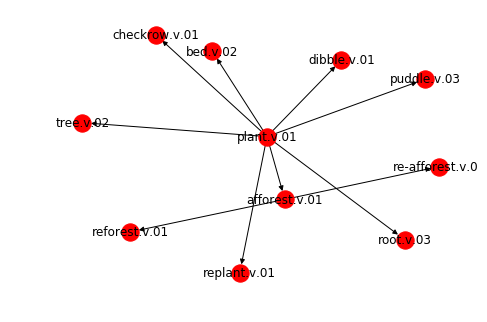

In [8]:
import networkx as nx

def closure_graph(synset, fn):
    is_seen = set()
    
    graph = nx.DiGraph()

    def recurse_call(syn):
        if not syn in is_seen:
            is_seen.add(syn)
            graph.add_node(syn.name())
            for s in fn(syn):
                graph.add_node(s.name())
                graph.add_edge(syn.name(), s.name())
                recurse_call(s)

    recurse_call(synset)
    return graph

# Draw the graph
graph = closure_graph(wordnet.synset('plant.v.01'), lambda s: s.hyponyms())
nx.draw(graph, with_labels = True)


Now we look at the reason why Lesk's Algorithm would fail.

Lesk doesn't consider synonyms and sometimes would fail because of unncessary function words.

In [9]:
fail_sent1 = word_tokenize("The green cover of plants look beautiful.")

fail_sent2 = word_tokenize("He set up a manufacturing plant in Surat.")

synset1 = lesk(fail_sent1, 'plant', 'n')
print(synset1, synset1.definition())

synset2 = lesk(fail_sent2, 'plant', 'n')
print(synset2, synset2.definition())

Synset('plant.n.02') (botany) a living organism lacking the power of locomotion
Synset('plant.n.03') an actor situated in the audience whose acting is rehearsed but seems spontaneous to the audience


Therfore we try to avoid Lesk and disambiguate using other techniques.
We can build a nice tool using NLTK to achieve that purpose.

In [10]:
def stem_and_syn(sentence):
    
    """
    This function will apply Stemming and Lemmatization on the input.
    We then add synonym words.
    """
        
    filtered_sent = []
    
    # lemmatizes the words.
    lemmatizer = WordNetLemmatizer()
    
    # stemmer stems the root of the word.
    stemmer = PorterStemmer()  

    # remove stop words.
    english_stop_words = stopwords.words("english")
    
    # Tokenize each word.
    words = word_tokenize(sentence)
    
    for w in words:
        if w not in english_stop_words + [',', '.', '?', "'"]:
            filtered_sent.append(lemmatizer.lemmatize(stemmer.stem(w)))
            for i in get_synonyms(w):
                filtered_sent.append(i)
                
    return list(set(filtered_sent))


def get_synonyms(word):
    
    """
    This function will find synset synonyms for the given word.
    """
    synonyms = [lemma.name() for syn in wordnet.synsets(word) for lemma in syn.lemmas()]
    
    return synonyms


In [11]:
def get_similarity(word1, word2):

    """
    This function calculates lin's similarity
    """
    
    word1 = word1 + ".n.01"
    word2 = word2 + ".n.01"
    
    try:
        
        w1 = wordnet.synset(word1)
        w2 = wordnet.synset(word2)
        
        return w2.wup_similarity(w1)

    except:
        # If there is any word for which synset doesn't exist.
        return 0


def filter_sentence(sentence):
    
    """
    This function will apply only lemmatization.
    """
    
    lemmatizer = WordNetLemmatizer()
    stop_words = stopwords.words("english")
    words = word_tokenize(sentence)

    filtered_sent = [lemmatizer.lemmatize(word) for word in words if word not in stop_words + [',', '.', '?', "'"]]
    
    return list(set(filtered_sent))

# Open training data set.
# Source: wikipedia

bio_plants = open("biological-plants.txt", 'r')
bio_text = bio_plants.read().lower()

ind_plants = open("industrial-plants.txt", 'r')
ind_text = ind_plants.read().lower()

user_query = ""

while user_query != "end":

    user_query = input('Enter a sentence in which you want to disambiguate the word "plant": ').lower()
    
    if user_query == 'end':
        break
    
    bio_similarity_score = 0
    ind_similarity_score = 0

    filtered_bio_text = filter_sentence(bio_text)
    filtered_ind_text = filter_sentence(ind_text)
    filtered_user_query = filter_sentence(user_query)

    for query_word in filtered_user_query:

        for bio_word in filtered_bio_text:
            bio_similarity_score += get_similarity(query_word, bio_word)

        for ind_word in filtered_ind_text:
            ind_similarity_score += get_similarity(query_word, ind_word)


    filtered_bio_text = stem_and_syn(bio_text)
    filtered_ind_text = stem_and_syn(ind_text)
    filtered_user_query = stem_and_syn(user_query)
    
    # We calculate the intersection count with the query word synonyms and data set synonyms.
    bio_interection_count = len([word for word in filtered_bio_text if word in filtered_user_query])
    ind_interection_count = len([word for word in filtered_ind_text if word in filtered_user_query])
    
    # print(bio_similarity_score, bio_interection_count, ind_similarity_score, ind_interection_count)
    
    if bio_interection_count + bio_similarity_score > ind_interection_count + ind_similarity_score:
        print("Biological Plant")
    else:
        print("Industrial Plant")

        
# Possible Queries:
# The green cover of plants look beautiful. ==> Biological Plant
# They set up a manufacturing plant in Surat. ==> Industrial Plant
# living organisms which require oxygen. ==> Biological Plant
# A large investment of land is required ==> Industrial Plant
# those who bear fruits and eatables ==> Biological Plant
# the one which causes tremendous pollution ==> Industrial Plant
# skilled labours work there ==> Industrial Plant
print("*" * 10)

Enter a sentence in which you want to disambiguate the word "plant": The green cover of plants look beautiful.
Biological Plant
Enter a sentence in which you want to disambiguate the word "plant": They set up a manufacturing plant in Surat.
Industrial Plant
Enter a sentence in which you want to disambiguate the word "plant": living organisms which require oxygen.
Biological Plant
Enter a sentence in which you want to disambiguate the word "plant": A large investment of land is required
Industrial Plant
Enter a sentence in which you want to disambiguate the word "plant": those who bear fruits and eatables
Biological Plant
Enter a sentence in which you want to disambiguate the word "plant": the one which causes tremendous pollution
Industrial Plant
Enter a sentence in which you want to disambiguate the word "plant": skilled labours work there
Industrial Plant
Enter a sentence in which you want to disambiguate the word "plant": end
**********


In conclusion, Lesk algorithm does well if we are looking for exact matches. We can achieve good results if we consider synomyms of the words. Additionally, a better data set would be even better as it would cover more vocabulary.

### References:
[1] https://towardsdatascience.com/a-simple-word-sense-disambiguation-application-3ca645c56357

[2] https://www.linkedin.com/pulse/wordnet-word-sense-disambiguation-wsd-nltk-aswathi-nambiar

[3] http://www.nltk.org/howto/wordnet.html

[4] http://www.randomhacks.net/2009/12/29/visualizing-wordnet-relationships-as-graphs/
